<a href="https://colab.research.google.com/github/yonilev2003/Assessing-Obesity-Risk-With-ML/blob/main/Obesity_Risk_Analaysis_%26_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Obesity has been recognized as a disease since June 2013. The following project tries to shed light on the characteristics of obesity. Although some characteristics might not have a causal relationship to obesity, finding and presenting obesity's common aspects is beneficial to raising awareness of obesity.

Obesity is determined using BMI levels. This metric is used to assess a person's body weight relative to their height. It is calculated by dividing a person's weight in kilograms by the square of their height in meters like so:
$$BMI=\frac{weight}{height^2}$$

Obesity levels by BMI:
* Underweight defined with >18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III >40

The dataset includes 2,111 rows and 17 columns:
* 'Gender' - either 'Male' or 'Female'
* 'Age' - between 14 and 61
* 'Height' - metric, between 1.45m to 1.98m
* 'Weight' - between 39 to 165 kg
* 'family_history_with_overweight' - yes/no
* 'FAVC' (frequent consumption of high calorie food) - yes/no
* 'FCVC' (frequency of consumption of vegetables) - yes/no
* 'NCP' (number of main meals) - between 1 to 4
* 'CAEC' (consumption of food between meals) - either sometimes, frequently, no, always
* 'SMOKE' (smoking habits) - yes/no
* 'CH2O' (consumption of water daily) - 1, 2, 3
* 'SCC' (calories consumption monitoring) - yes/no
* 'FAF' (physical activity frequency) - between 0 and 3, where 0 means no physical activity, and 3 means high-frequency workouts regiment.
* 'TUE' (time using technology devices) - between 0 to 2 (from a caveman to couch potato binging Netflix).
* 'CALC' (consumption of alcohol) - sometimes, no, frequently
* 'MTRANS' (main transportation mode) - public transportation, automobile, walking, motorbike, bike
* 'NObeyesdad' - insufficient_weight, normal weight, overweight_level_I, overweight_level_II, obesity_type_I, Obesity_Type_II, Obesity_Type_III

# Imports & Installations

In [370]:
# Installing the Kaggle API package
! pip install kaggle

In [371]:
# Installing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Setting numpy error handling to ignore invalid values
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [372]:
# Setting Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'yonathanlevy'
os.environ['KAGGLE_KEY'] = 'd161e19bbcf37f55b9e5a0d6e5497e55'

In [373]:
# Download the dataset directly from Kaggle
!kaggle datasets download -d aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster -p /content

# Unzip the dataset
!unzip /content/obesity-or-cvd-risk-classifyregressorcluster.zip -d /content/obesity-dataset

obesity-or-cvd-risk-classifyregressorcluster.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/obesity-or-cvd-risk-classifyregressorcluster.zip
replace /content/obesity-dataset/ObesityDataSet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [374]:
# Loading the dataset
data = pd.read_csv("/content/obesity-dataset/ObesityDataSet.csv")

# Looking at the first 5 rows
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Cleaning & Analysis

At a first glance of the cleaning, there are no missing values, the data types are appropriate, and there are no categorical anomalies. There were 24 duplicates, I removed them.

In [375]:
# Checking for duplicates
data.duplicated().sum()

24

In [376]:
# Dropping duplicates
data.drop_duplicates(inplace=True)
print("Number of duplicates after removal:", data.duplicated().sum())

Number of duplicates after removal: 0


In [377]:
# Checking for any anomalies in categorical columns (e.g., inconsistent labels)
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_anomalies = {column: data[column].unique() for column in categorical_columns}
categorical_anomalies

{'Gender': array(['Female', 'Male'], dtype=object),
 'family_history_with_overweight': array(['yes', 'no'], dtype=object),
 'FAVC': array(['no', 'yes'], dtype=object),
 'CAEC': array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object),
 'SMOKE': array(['no', 'yes'], dtype=object),
 'SCC': array(['no', 'yes'], dtype=object),
 'CALC': array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object),
 'MTRANS': array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
        'Bike'], dtype=object),
 'NObeyesdad': array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
        'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
        'Obesity_Type_III'], dtype=object)}

In [378]:
# Dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   float64
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   float64
 7   NCP                             2087 non-null   float64
 8   CAEC                            2087 non-null   object 
 9   SMOKE                           2087 non-null   object 
 10  CH2O                            2087 non-null   float64
 11  SCC                             2087 non-null   object 
 12  FAF                             20

In [379]:
# Descriptive info
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,24.353090,1.702674,86.858730,2.421466,2.701179,2.004749,1.012812,0.663035
std,6.368801,0.093186,26.190847,0.534737,0.764614,0.608284,0.853475,0.608153
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.915937,1.630178,66.000000,2.000000,2.697467,1.590922,0.124505,0.000000
50%,22.847618,1.701584,83.101100,2.396265,3.000000,2.000000,1.000000,0.630866
75%,26.000000,1.769491,108.015907,3.000000,3.000000,2.466193,1.678102,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


**The target variable**

'NObeyesdad' is the target variable, representing the person's BMI. The column values are:
* Insufficient_Weight : Less than 18.5
* Normal_Weight : 18.5 to 24.9
* Obesity_Type_I : 30.0 to 34.9
* Obesity_Type_II : 35.0 to 39.9
* Obesity_Type_III : Higher than 40
* Overweight_Level_I, Overweight_Level_II takes values between 25 to 29

I replaced the names of the values:
* Insufficient_Weight = 'underweight'
* Normal_Weight = 'normal'
* Overweight_Level_I, Overweight_Level_II = I merged and named 'overweight'
* Obesity_Type_I = obesity_class_I
* Obesity_Type_II = obesity_class_II
* Obesity_Type_III = obesity_class_III

In [380]:
# Defining the mapping for renaming categories
category_mapping = {
    'Insufficient_Weight': 'underweight',
    'Normal_Weight': 'normal',
    'Overweight_Level_I': 'overweight',
    'Overweight_Level_II': 'overweight',
    'Obesity_Type_I': 'obesity_class_I',
    'Obesity_Type_II': 'obesity_class_II',
    'Obesity_Type_III': 'obesity_class_III'
}

# Replacing values in the 'NObeyesdad' column according to the mapping
data['NObeyesdad'] = data['NObeyesdad'].replace(category_mapping)

# Confirm the changes
print(data['NObeyesdad'].unique())

['normal' 'overweight' 'obesity_class_I' 'underweight' 'obesity_class_II'
 'obesity_class_III']


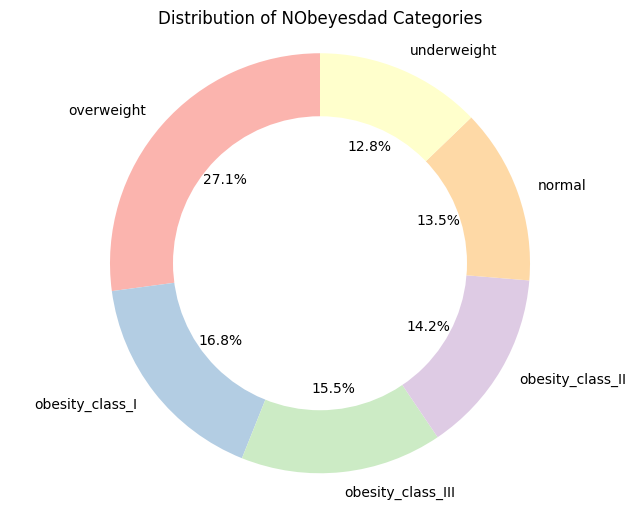

In [381]:
# Visualizing the target variable 'NObeyesdad' using a donut visualization
# Counting the occurrences of each category
category_counts = data['NObeyesdad'].value_counts()

# Define lighter shades of the rainbow colors
colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd']

# Plotting a donut chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')

plt.title('Distribution of NObeyesdad Categories')
plt.show()

**Defining the numerical and categorical columns**

In [382]:
# Defining the numerical and categorical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

# Remove the 'NObeyesdad' target variable from categorical columns if it's there
if 'NObeyesdad' in categorical_columns:
    categorical_columns.remove('NObeyesdad')

**Visualizing the numerical columns**

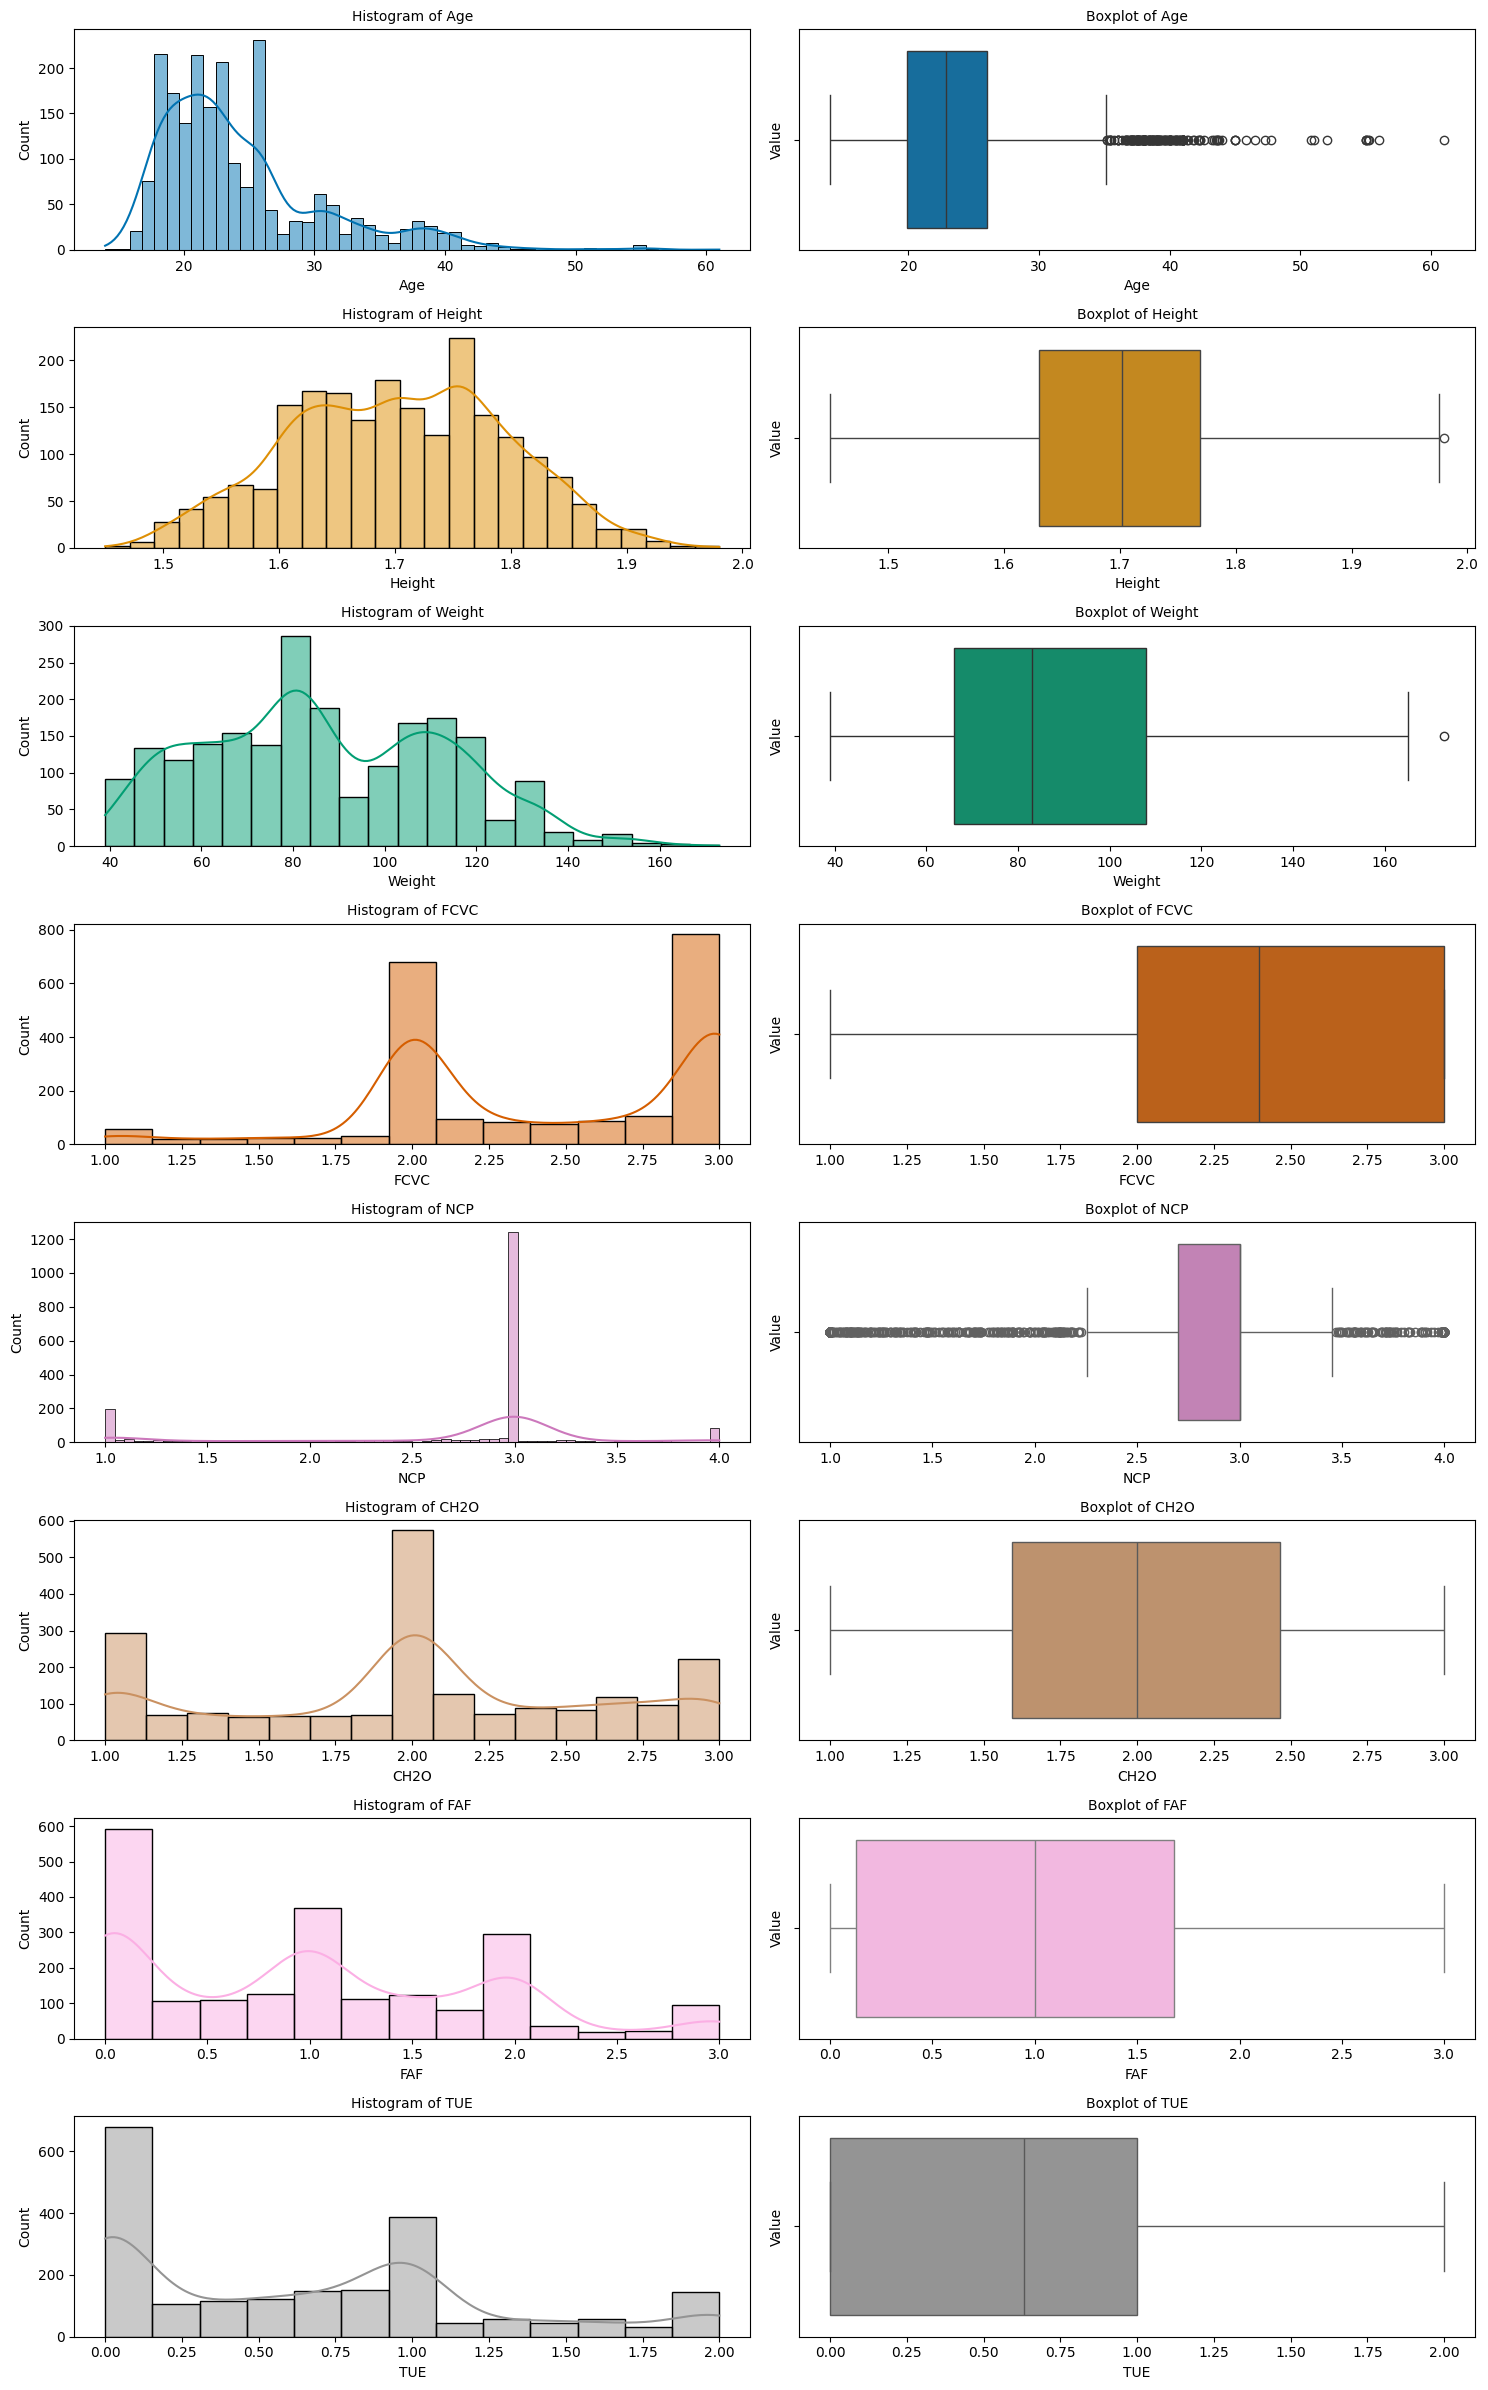

In [383]:
# Generate a colorblind-friendly palette with as many colors as there are numerical columns
palette = sns.color_palette("colorblind", num_rows)

# Create a figure and axes for the subplots with the colorblind palette
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 3 * num_rows))

for i, col in enumerate(numerical_columns):
    # Histogram on the left
    sns.histplot(data[col], ax=axes[i, 0], kde=True, color=palette[i])
    axes[i, 0].set_title(f'Histogram of {col}', fontsize=10)
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # Boxplot on the right to show outliers
    sns.boxplot(x=data[col], ax=axes[i, 1], color=palette[i])
    axes[i, 1].set_title(f'Boxplot of {col}', fontsize=10)
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Value')

fig.tight_layout()
plt.show()

**Statistical tests:**

To analyze the correlation between numerical columns and the categorical target variable 'NObeyesdad', I converted the target variable into a numerical code. Then, I calculated Spearman's rank correlation coefficient for each numerical column.

Based on the p-values, all numerical columns except for TUE show a statistically significant correlation with 'NObeyesdad' levels. The Weight variable has the highest correlation coefficient, suggesting a strong positive relationship with obesity levels (qutie obvious, isn't it?). TUE shows a very weak and non-significant correlation, implying that time using technology devices might not be a good indicator of obesity levels in this dataset.

In [384]:
# Converting 'NObeyesdad' into a numerical code
obesity_level = {level: code for code, level in enumerate(data['NObeyesdad'].unique())}
data['NObeyesdad_code'] = data['NObeyesdad'].map(obesity_level)

# Calculating Spearman's rank correlation coefficient for each numerical column
spearman_correlation = {}
for col in numerical_columns:
    spearman_corr, p_value = spearmanr(data[col], data['NObeyesdad_code'])
    spearman_correlation[col] = {'Spearman Correlation': spearman_corr, 'p-value': p_value}

# Compiling the results into a DataFrame for easier reading
spearman_correlation_df = pd.DataFrame(spearman_correlation).transpose()
spearman_correlation_df

,Spearman Correlation,p-value
Age,0.165715,2.562663e-14
Height,0.121623,2.495590e-08
Weight,0.616649,6.807131e-219
FCVC,0.378699,3.777430e-72
NCP,0.126568,6.553680e-09
CH2O,0.104419,1.748886e-06
FAF,-0.099400,5.377689e-06
TUE,-0.004736,8.288176e-01


**Visualizing the numerical columns by 'NObeyesdad' level**

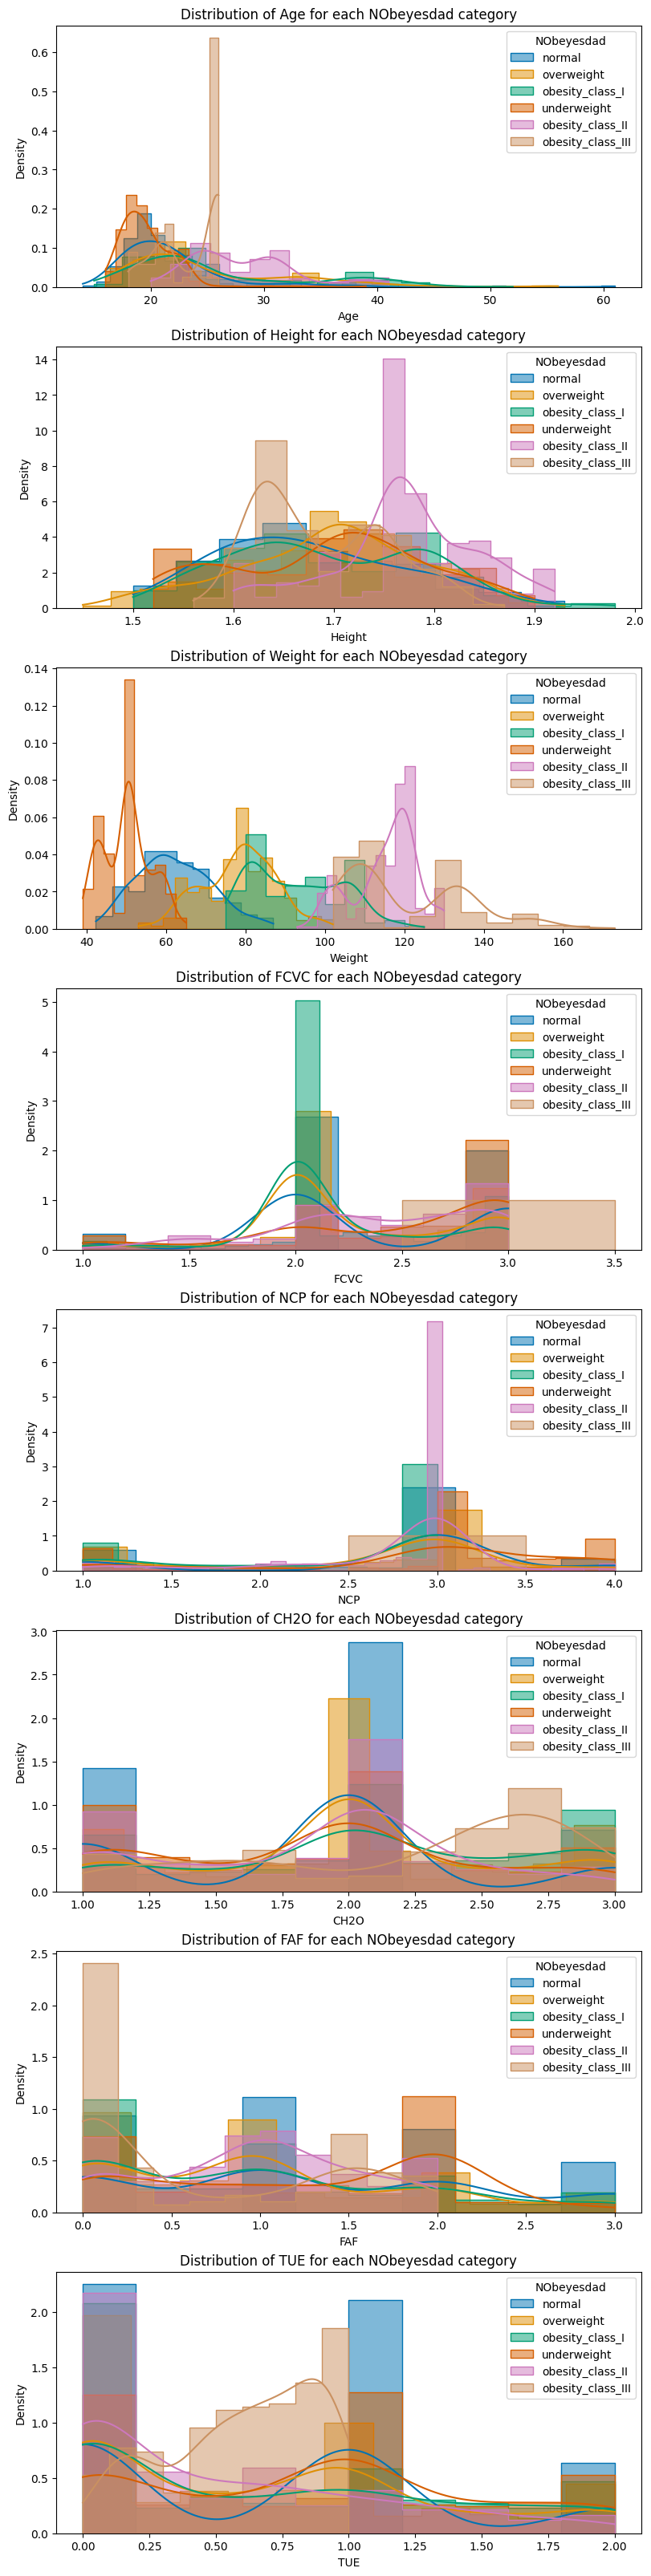

In [385]:
# We will visualize the distribution of each numerical column by 'NObeyesdad' category using histograms.

# Set up the matplotlib figure for numerical distributions using histograms
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(8, 4 * len(numerical_columns)), constrained_layout=True)

# Use a colorblind-friendly palette
palette = sns.color_palette("colorblind", len(data['NObeyesdad'].unique()))

# Plot the histograms for each 'NObeyesdad' category within each numerical column
for ax, col in zip(axes, numerical_columns):
    # Create a histogram for each category of 'NObeyesdad'
    for i, category in enumerate(data['NObeyesdad'].unique()):
        subset = data[data['NObeyesdad'] == category]
        sns.histplot(subset[col], label=category, color=palette[i], ax=ax, element='step', stat="density", kde=True)
    ax.set_title(f'Distribution of {col} for each NObeyesdad category')
    ax.legend(title='NObeyesdad')

plt.show()


**Visualizing the 'NObeyesdad' levels by age group**

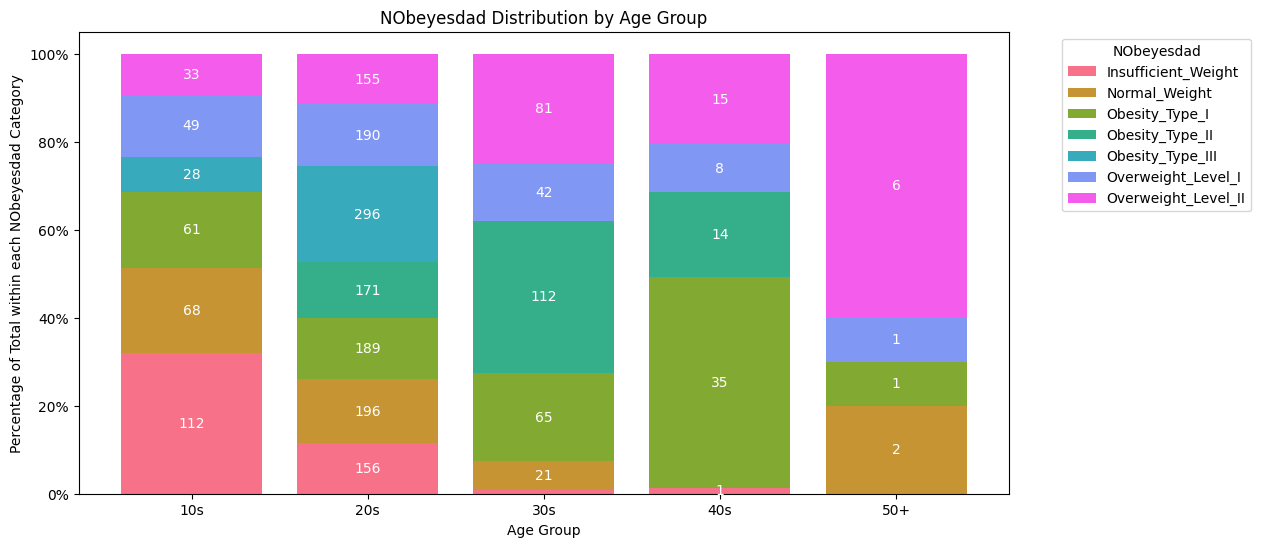

In [386]:
# Create a color palette with unique colors for each 'NObeyesdad' category
unique_nobeyesdad_levels = age_group_distribution['NObeyesdad'].unique()
colors = sns.color_palette("husl", len(unique_nobeyesdad_levels))
color_dict = dict(zip(unique_nobeyesdad_levels, colors))

# Create a figure and axes for the Mekko chart
fig, ax = plt.subplots(figsize=(12, 6))

# The bottom position for the age groups on the y-axis
bottoms = np.zeros(len(labels))

# Loop through each 'NObeyesdad' level and stack them on top of each other for each age group
for level in unique_nobeyesdad_levels:
    # Filter the data for the current 'NObeyesdad' level
    level_data = age_group_distribution[age_group_distribution['NObeyesdad'] == level]
    # Ensure the order of the age groups matches the labels
    level_data = level_data.set_index('age_group').reindex(labels).reset_index()
    # Plot
    ax.bar(level_data['age_group'], level_data['percentage'], bottom=bottoms, label=level,
           color=color_dict[level])

    # Add the count labels on top of each bar segment
    for i, (pct, count) in enumerate(zip(level_data['percentage'], level_data['count'])):
        if pct > 0.01:  # Only add labels to large enough segments to avoid clutter
            ax.text(i, bottoms[i] + pct/2, f'{count}', ha='center', va='center', color='white')

    # Update the bottoms position for the next 'NObeyesdad' level
    bottoms += level_data['percentage'].values

# Set the y-axis as percentages
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and title
ax.set_xlabel('Age Group')
ax.set_ylabel('Percentage of Total within each NObeyesdad Category')
ax.set_title('NObeyesdad Distribution by Age Group')

# Display the legend
ax.legend(title='NObeyesdad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

**Visualizing the categorical columns**

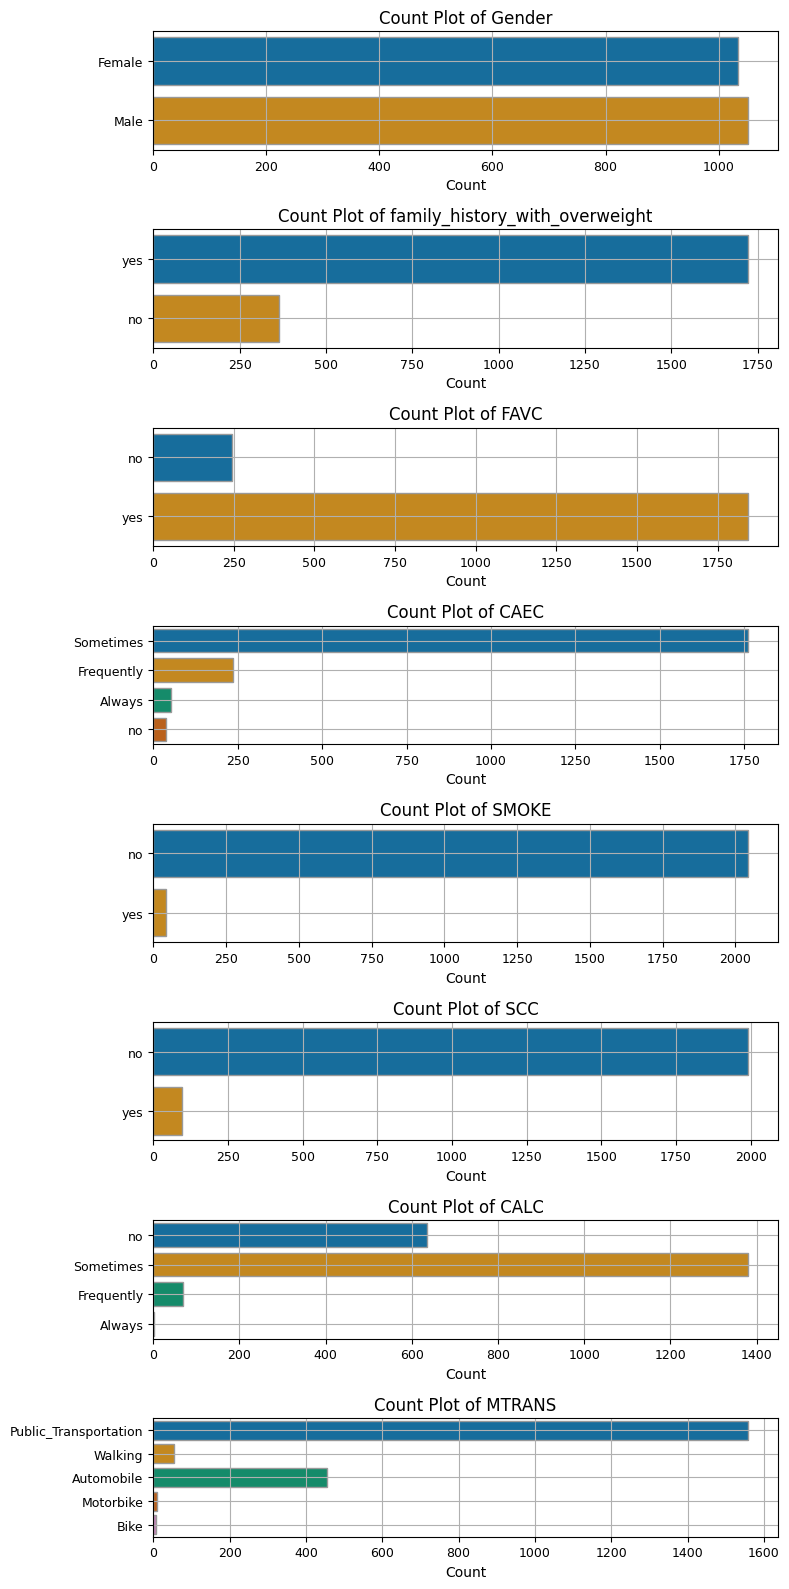

In [387]:
# Setting the color palette globally
sns.set_palette('colorblind')

# Defining the dimensions of the grid
grid_rows = len(categorical_columns)
grid_cols = 1

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(8, 2 * grid_rows))

# Looping through the categorical columns and create a count plot for each
for i, col in enumerate(categorical_columns):
    ax = sns.countplot(y=col, data=data, ax=axes[i], hue=col, palette="colorblind", edgecolor=".6")
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    axes[i].set_title(f'Count Plot of {col}', fontsize=12)
    axes[i].set_xlabel('Count', fontsize=10)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', which='major', labelsize=9)
    axes[i].grid(True)

# Adjusting the layout
plt.tight_layout()
plt.show()

**Statistical tests:**

To analyze the correlation between the categorical columns and the target variable, I used the already converted target variable and a chi-squared test.

Based on the p-values, all categorical columns show statistically significant relationship with 'NObeyesdad'.

In [388]:
# Calculating Chi-squared test statistic for each categorical column
chi_squared_results = {}

for col in categorical_columns_to_visualize:
    # Create a contingency table
    contingency_table = pd.crosstab(data[col], data['NObeyesdad_code'])
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_squared_results[col] = {'Chi-squared Statistic': chi2, 'p-value': p}

# Compiling the results into a DataFrame for easier reading
chi_squared_df = pd.DataFrame(chi_squared_results).transpose()

# Dropping 'NObeyesdad_code'
data.drop(columns=['NObeyesdad_code'], inplace=True)

chi_squared_df

,Chi-squared Statistic,p-value
Gender,641.067955,2.698162e-136
family_history_with_overweight,585.718205,2.463101e-124
FAVC,188.957165,6.526998e-39
CAEC,679.924782,3.521568e-135
SMOKE,31.576530,7.205815e-06
SCC,81.421793,4.229736e-16
CALC,288.568972,1.320419e-52
MTRANS,280.097029,9.184783e-48


**Visualizing every categorical columns' correlation with 'NObeyesdad':**

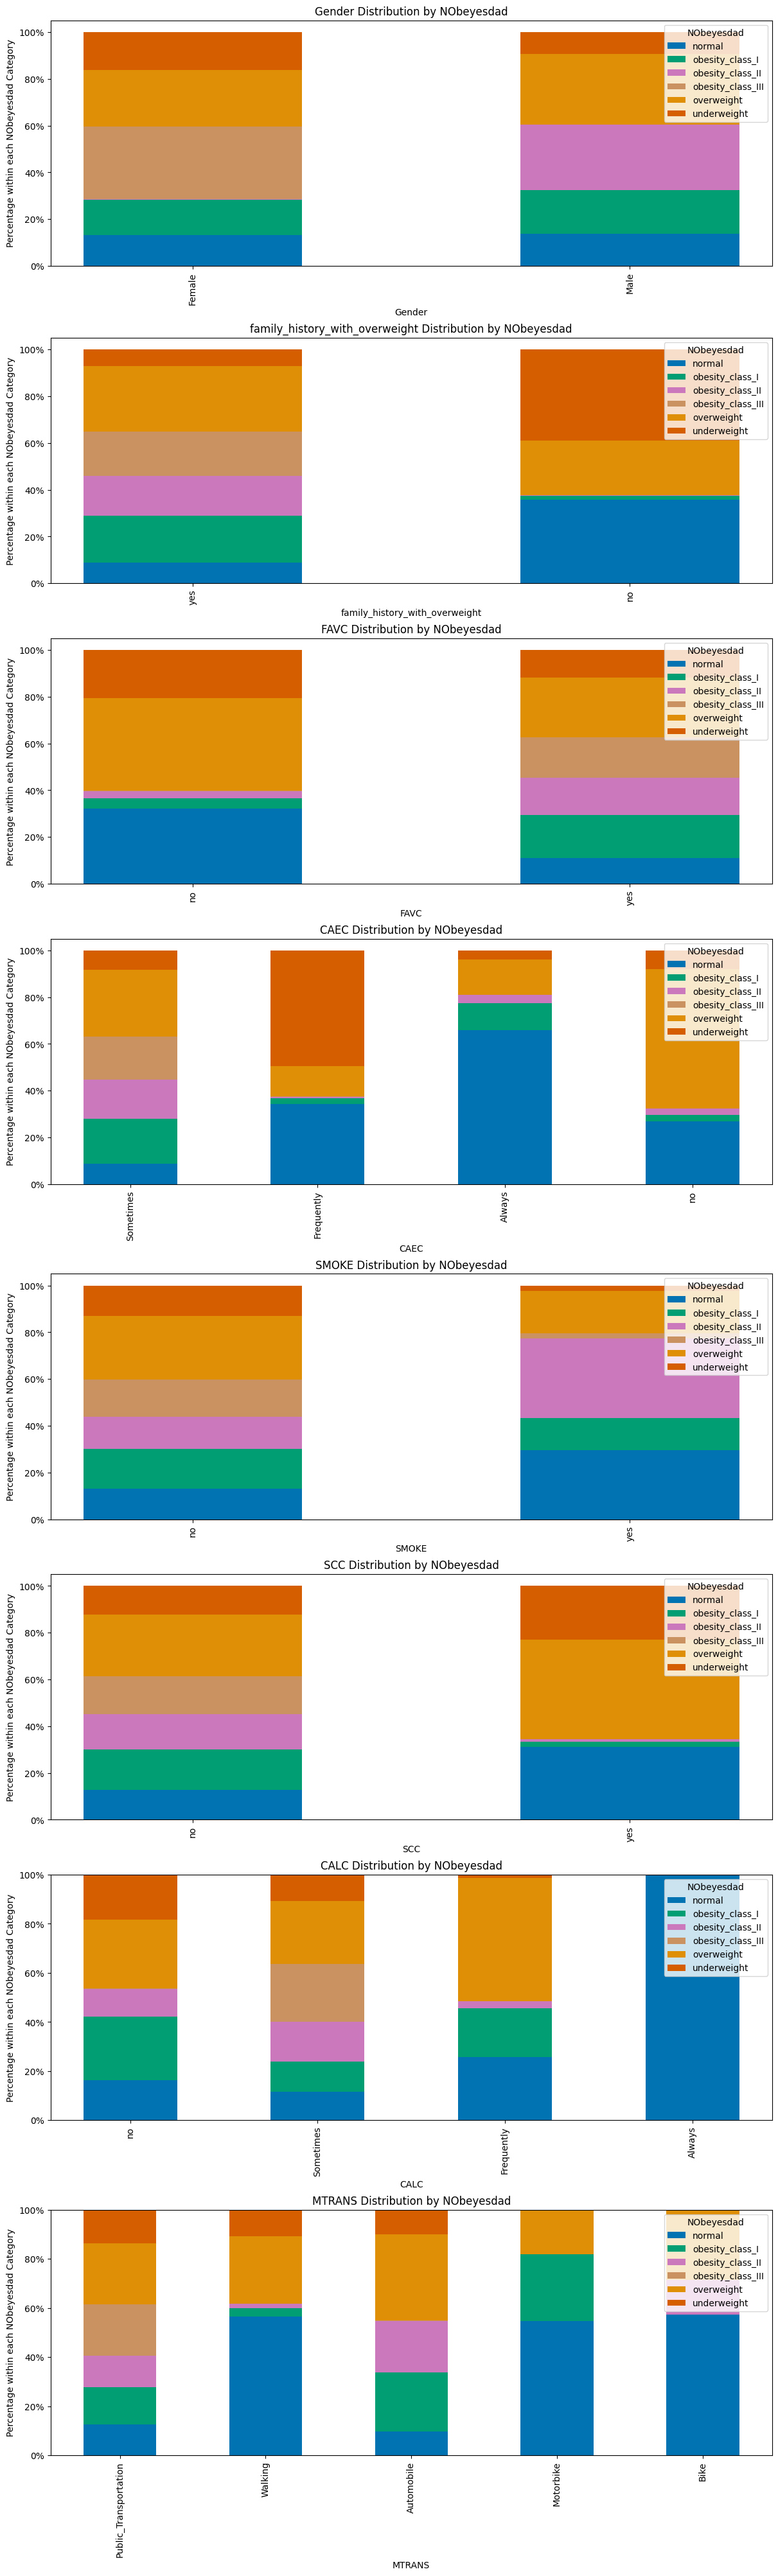

In [389]:
# Defining a colorblind-friendly palette for each 'NObeyesdad' category
unique_nobeyesdad_levels = data['NObeyesdad'].unique()
nobeyesdad_palette = sns.color_palette("colorblind", len(unique_nobeyesdad_levels))

# Creating a Mekko chart for each categorical column
fig, axes = plt.subplots(nrows=len(categorical_columns_to_visualize), ncols=1, figsize=(12, 5 * len(categorical_columns_to_visualize)), constrained_layout=True)

# Flattening the axes array for easy iteration if it's multidimensional
if len(categorical_columns_to_visualize) == 1:
    axes = [axes]

# Looping over each categorical column to create a Mekko chart for each
for i, column in enumerate(categorical_columns_to_visualize):
    # Calculate the count and percentage of each 'NObeyesdad' category by column value
    column_distribution = data.groupby([column, 'NObeyesdad']).size().reset_index(name='count')
    column_totals = column_distribution.groupby(column)['count'].transform('sum')
    column_distribution['percentage'] = column_distribution['count'] / column_totals
    bottoms = np.zeros(len(data[column].unique()))

    # Sorting the 'NObeyesdad' levels to ensure consistent color mapping
    sorted_levels = column_distribution['NObeyesdad'].unique()
    sorted_levels.sort()

    # Plotting each 'NObeyesdad' level
    for level in sorted_levels:
        level_data = column_distribution[column_distribution['NObeyesdad'] == level]
        level_data = level_data.set_index(column).reindex(data[column].unique(), fill_value=0).reset_index()
        axes[i].bar(level_data[column], level_data['percentage'], bottom=bottoms, width=0.5,
                    label=level, color=nobeyesdad_palette[unique_nobeyesdad_levels.tolist().index(level)])
        bottoms += level_data['percentage'].values

    axes[i].set_title(f'{column} Distribution by NObeyesdad')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Percentage within each NObeyesdad Category')
    axes[i].xaxis.set_tick_params(rotation=90)
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

    axes[i].legend(title='NObeyesdad', loc='upper right')

# Show the plot
plt.show()

**Some insights**

1. There is a notable difference in obesity distribtuions between genders. Women tend for both being underweight and having class 3 obesity more than men.
2. A family history of overweight is significantly associated with higher obesity levels.
3. High caloric food consumption and consumption of food between meals is more common among individuals with higher obesity levels.
4. People who monitor their calorie consumption are less prevalent in higher obesity levels, *supporting the idea that awareness of intake is crucial in obesity prevention.**
5. Active modes of transportation (like walking and biking) are less common in higher obesity levels.

# Preparing for ML

**Feature engineering:**

To prepare the data for ML, I made my own customization to raise potential accuracy.
1. Creating a new 'decade' column (14-19 as 10s, 20-29 as 20s, 30-39 as 30s, 40-49 as 40s, 50 and more as 50+), and dropping the 'age' column.
2. Rounding up heights to the nearest decimal.
3. Rounding up weights to the nearest integer.
4. Mapping CAEC values to numerical as follows: No = 1, Sometimes = 2, Frequently = 3, Always = 4.
5. Mapping CALC values to numerical as follows: No = 1, Sometimes = 2, Frequently = 3, Always = 4.

In [390]:
# Creating a new 'decade' column and dropping the 'age' column
bins = [14, 20, 30, 40, 50, float('inf')]
labels = ['10s', '20s', '30s', '40s', '50+']
data['decade'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
data.drop(columns=['Age'], inplace=True)

In [391]:
# Rounding heights
data['Height'] = data['Height'].apply(lambda x: round(x * 2) / 2)

In [392]:
# Rounding weights
data['Weight'] = data['Weight'].apply(lambda x: np.ceil(x))

In [393]:
# Mapping CAEC values to numerical
caec_mapping = {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4}
data['CAEC'] = data['CAEC'].map(caec_mapping)

In [394]:
# Mapping CALC
calc_mapping = {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4}
data['CALC'] = data['CALC'].map(calc_mapping)

In [395]:
# Rounding up some of the columns to the nearest integer
columns_to_round = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
data[columns_to_round] = data[columns_to_round].apply(np.ceil)

**Identifying the feature columns and target column**

In [396]:
feature_cols = [col for col in data.columns if col != 'NObeyesdad']
X = data[feature_cols]
y = data['NObeyesdad']

**Splitting the data into training and testing sets**

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Re-defining the numerical and categorical columns and setting them as features**

Because of the feature engineering, I needed to redefine numerical and categorical columns as the features.

In [398]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

**Creating the preprocessing pipelines for both numerical and categorical data**

In [399]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

**Bundle preprocessing for numerical and categorical data**

In [400]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

**Creating a preprocessing and modeling pipeline**

In [401]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

**Applying transformations to the training and the testing data**

In [402]:
X_train_transformed = model_pipeline.fit_transform(X_train)
X_test_transformed = model_pipeline.transform(X_test)

**Feature Importance with RandomForest**

In [403]:
# Instantiating the RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, random_state=42)

# Fitting the RandomForestClassifier to the transformed training data
rf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

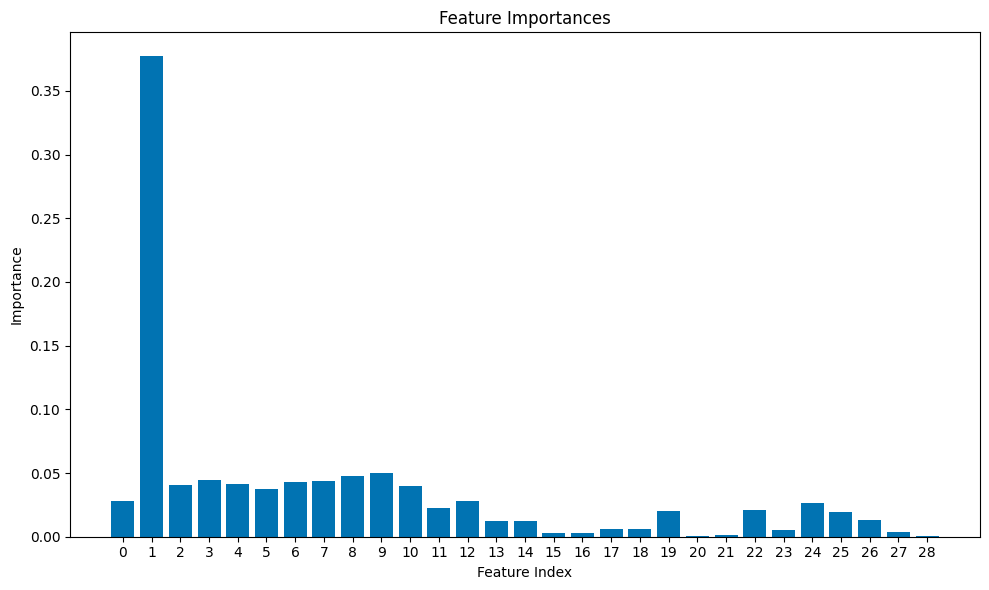

In [404]:
# Feature Importance
feature_importances = rf.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_transformed.shape[1]), feature_importances, align="center")
plt.xticks(range(X_train_transformed.shape[1]), range(X_train_transformed.shape[1]))
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [405]:
# Calculate the number of features with importance less than 1%, 0.5%, and 0.1%
features_less_than_1_percent = sum(feature_importances < 0.01)
features_less_than_half_percent = sum(feature_importances < 0.005)
features_less_than_tenth_percent = sum(feature_importances < 0.001)

features_less_than_1_percent, features_less_than_half_percent, features_less_than_tenth_percent

(9, 6, 3)

# ML

I used ensemble methods to run 3 models: logistic regression, random forest and gradient boosting. The accuracy of the last 2 is 93%, which is impressive yet there is a posibility to overfitting.

Below the ensemble methods I dropped all the features with importance lower than 1%, which are 9. Then, I re-trained a new RandomForest model with the reduced features and recieved a 92.1% accuracy. It means that even after the decreasing of features, the model still retains most of its predictive power. It indicates that the model was not heavily overfitted from the first place, and that the model is robust.

**In other words, it's an excelent model.**

In [406]:
# Ensemble methods
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Fit the model
    if name == "Logistic Regression":
        model.fit(X_train_transformed, y_train)
        y_score = model.predict_proba(X_test_transformed)
    else:
        model.fit(X_train_transformed, y_train)
        y_pred = model.predict(X_test_transformed)
        y_pred_prob = model.predict_proba(X_test_transformed)
        y_score = label_binarize(y_pred, classes=np.unique(y))

    # ROC AUC
    if name == "Logistic Regression":
        roc_auc = roc_auc_score(y_test, y_score, average="macro", multi_class="ovr")
    else:
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

    # Classification report
    if name != "Logistic Regression":
        report = classification_report(y_test, y_pred)
    else:
        y_pred_multi = np.argmax(y_score, axis=1)
        y_pred_multi = [np.unique(y)[x] for x in y_pred_multi]
        report = classification_report(y_test, y_pred_multi)

    results[name] = {"ROC AUC": roc_auc, "Classification Report": report}

results

{'Logistic Regression': {'ROC AUC': 0.9498574964267595,
  'Classification Report': '                   precision    recall  f1-score   support\n\n           normal       0.71      0.57      0.64        61\n  obesity_class_I       0.64      0.51      0.57        70\n obesity_class_II       0.84      0.97      0.90        64\nobesity_class_III       1.00      1.00      1.00        60\n       overweight       0.63      0.77      0.70       104\n      underweight       0.91      0.81      0.86        59\n\n         accuracy                           0.77       418\n        macro avg       0.79      0.77      0.78       418\n     weighted avg       0.77      0.77      0.76       418\n'},
 'Random Forest': {'ROC AUC': 0.9934700181959703,
  'Classification Report': '                   precision    recall  f1-score   support\n\n           normal       0.81      0.82      0.81        61\n  obesity_class_I       0.97      0.93      0.95        70\n obesity_class_II       1.00      0.98      0.99

In [407]:
# Dropping the 9 least important features
least_important_features = np.argsort(feature_importances)[:9]

# Dropping these features from the dataset
X_dropped_9 = np.delete(X_train_transformed, least_important_features, axis=1)
X_test_dropped_9 = np.delete(X_test_transformed, least_important_features, axis=1)

# Training a new RandomForest model with the reduced set of features
rf_dropped_9 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dropped_9.fit(X_dropped_9, y_train)

# Evaluating the new model's accuracy
accuracy_dropped_9 = rf_dropped_9.score(X_test_dropped_9, y_test)

# Number of features dropped and the new accuracy
least_important_features, accuracy_dropped_9

(array([20, 28, 21, 15, 16, 27, 23, 17, 18]), 0.9210526315789473)